notes to self
-logarithmic scaling since thereare so many outliers -> could be exponential response variable
-there is high dimensionality so may need to do some dimensionality reduction
-classifying the data could be determined via clusters or numerical -> want to see groupings based on chemical that was ran

## Import Modules & Data

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
d_path = base_fpath.replace('notebooks', 'data') #raw data file path

s_data = pd.read_csv(d_path + '/gas_data_cleaned.csv') #sensor data

## Break the data into sub-groups based on the element

There are 128 independent variables which means there is high dimensionality. let's look at a correlation matrix to see if any of the independent variables are highly correlated.

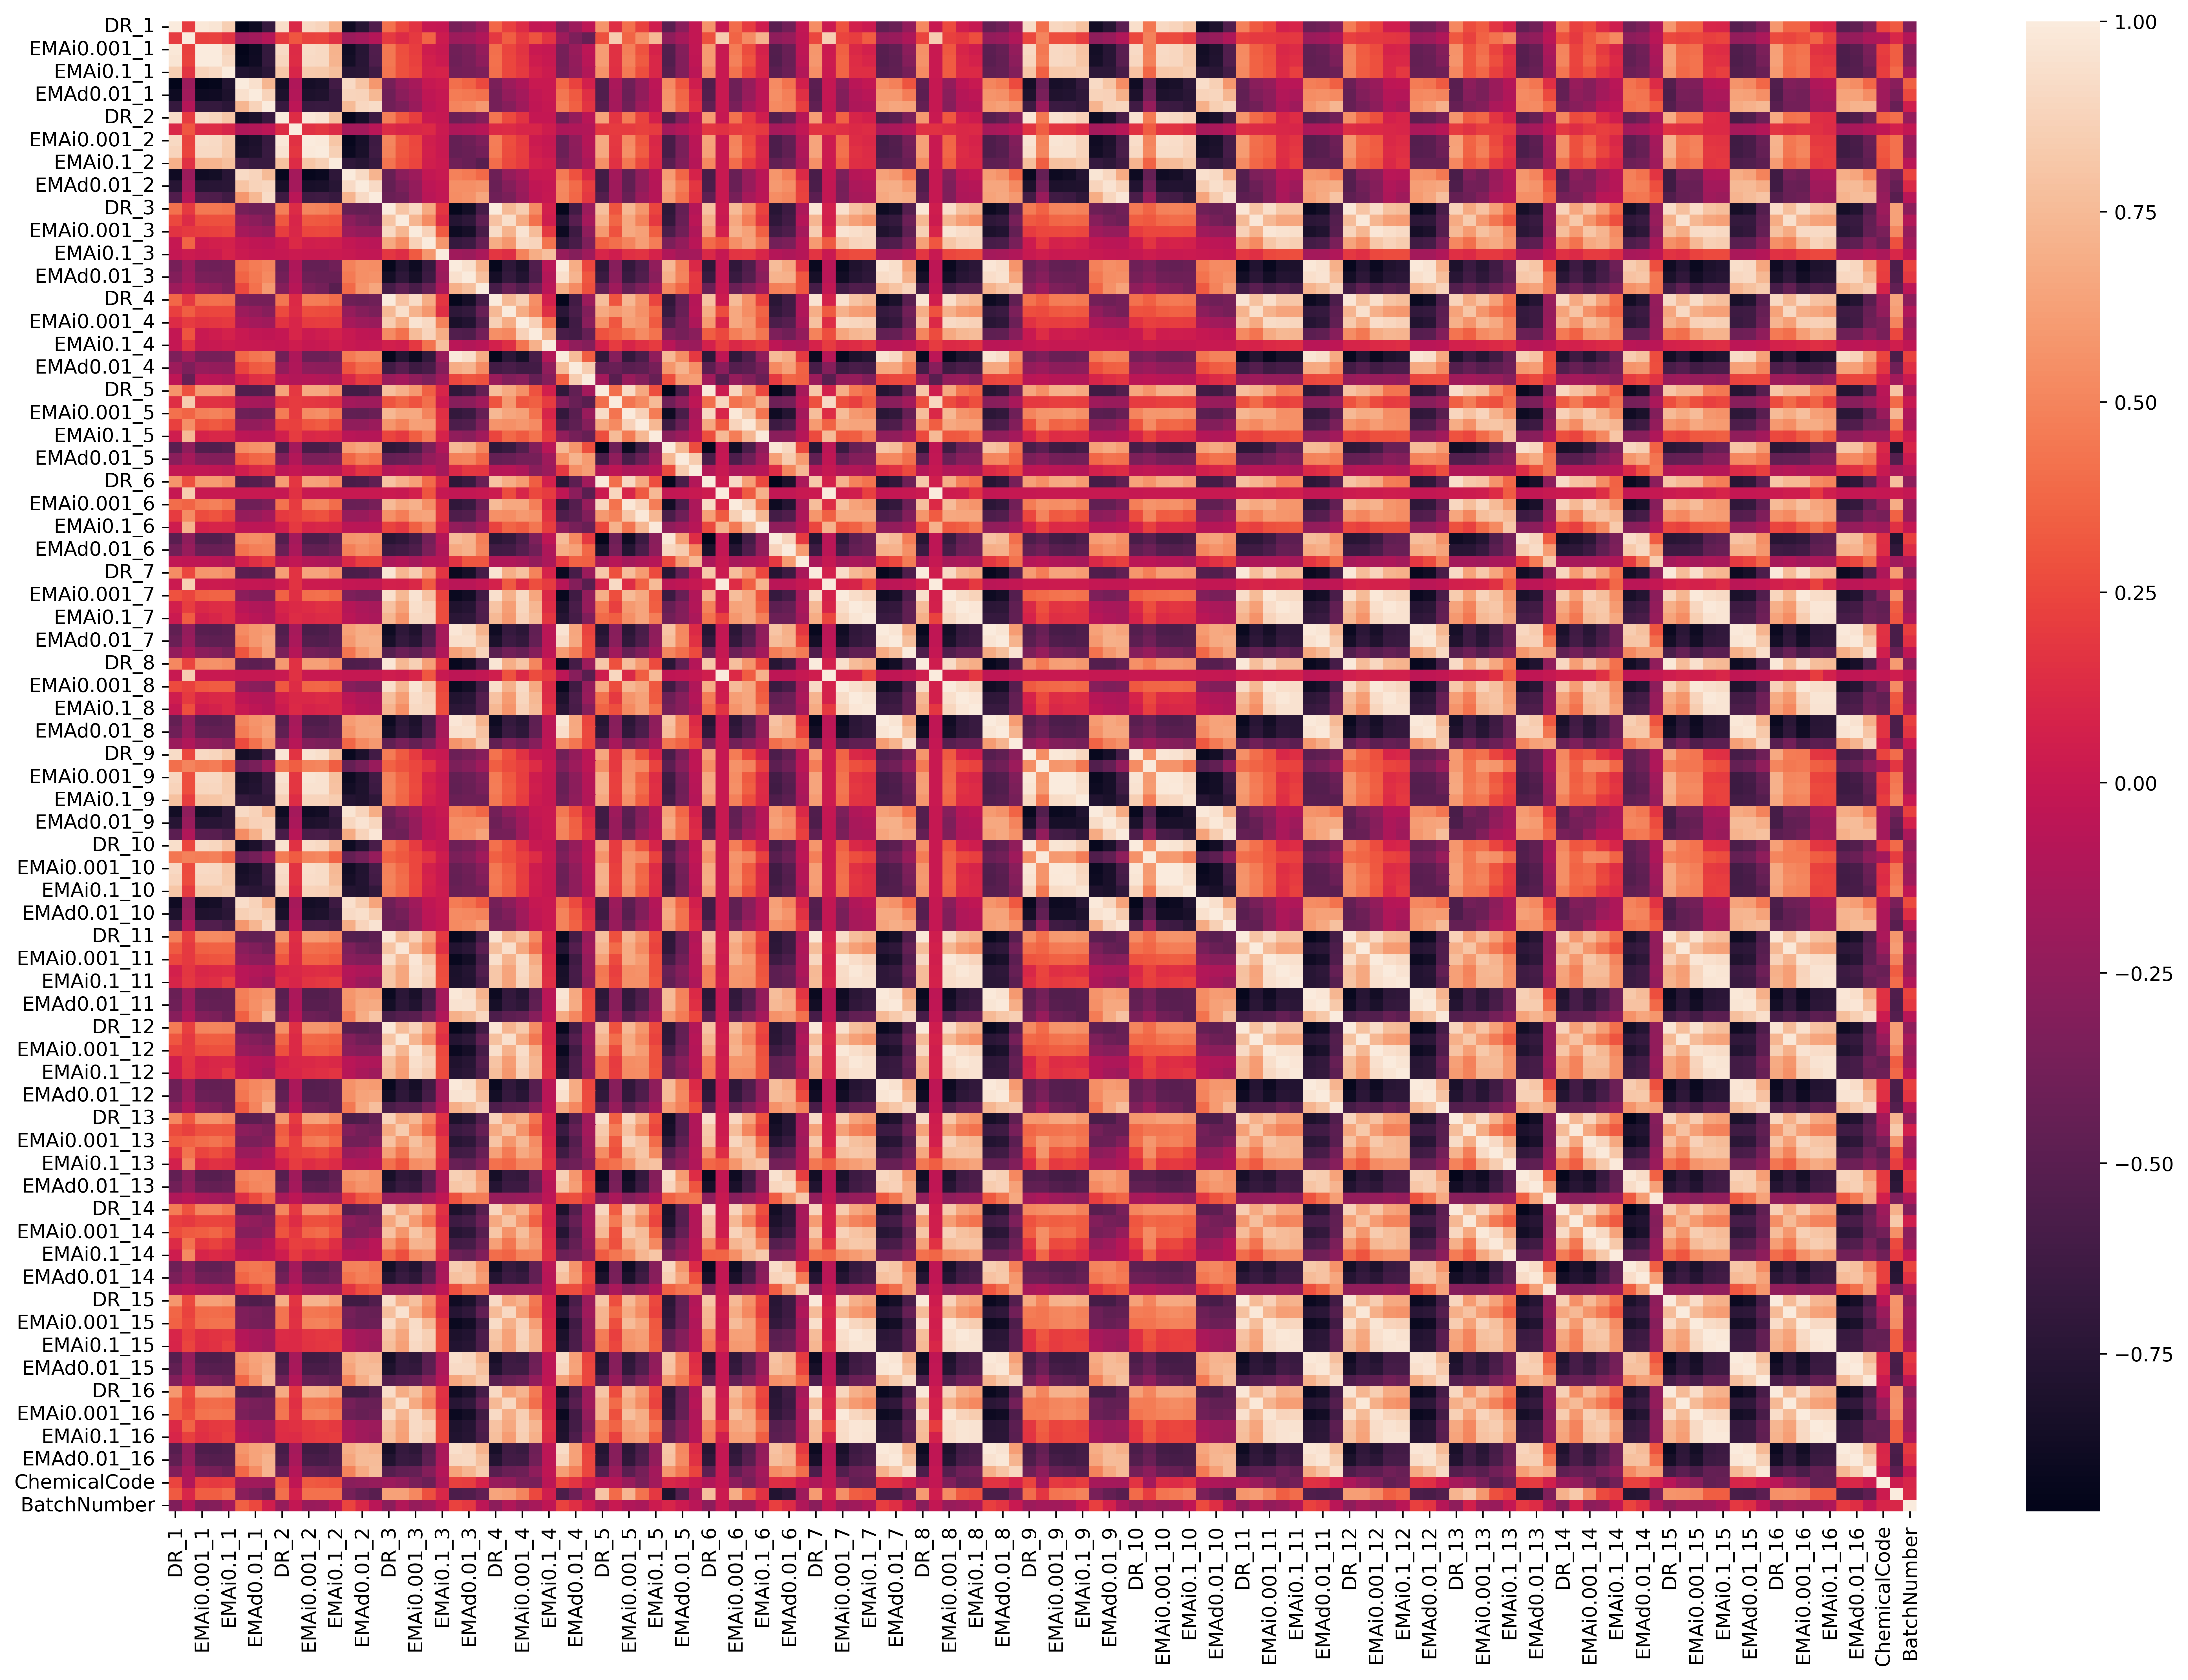

In [12]:
#lets first look at a correlation matrix
fig = plt.figure(figsize=(20,14), dpi=500)
sns.heatmap(s_data.corr());

Looks like there is large number of variables that are highly (either positively or negatively) correlated to each other meaning we should be able to reduce the number of independent variables we use without too much of the explained variance of the dataset.

Out of curiosity, let's examine if any variables are highly correlated to the chemical code.

In [43]:
chem_corr = s_data.corr()['ChemicalCode']
chem_corr.drop(index=['ChemicalCode', 'BatchNumber', 'Concentration'], inplace=True) #eliminate the dependent variables
chem_corr[abs(chem_corr) > .5]

EMAi0.01_13   -0.500287
EMAi0.01_14   -0.513988
Name: ChemicalCode, dtype: float64

so only two variables have correlation coefficient greater than 0.5 with respect to the chemical code. let's create a scatter plot of these two variables with the data points colored based on the chemical code.

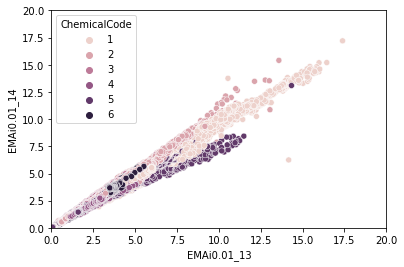

In [47]:
sns.scatterplot(x='EMAi0.01_13', y='EMAi0.01_14', data=s_data, hue='ChemicalCode');
plt.xlim([0, 20]); #do not show the two outliers
plt.ylim([0, 20]); #do not show the two outliers

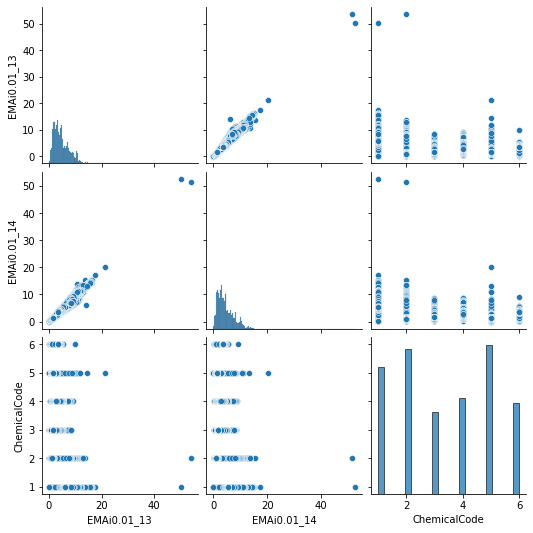

In [48]:
sns.pairplot(s_data[['EMAi0.01_13', 'EMAi0.01_14', 'ChemicalCode']])

it doesn't look like we are as lucky as we thought because these two variables are not sufficient to determine the chemical code. The distributions at each chemical code overlap each other significantly.

In [6]:
high_corr2 = [] #list for combonations that have a high correlation
corr_matrix = s_data[used_cols].corr() #Correlation matrix
c_list = list(corr_matrix.columns) #list of variable names
for c in c_list:
    for i in c_list:
        if abs(corr_matrix.loc[i,c]) > 0.8: #determine if it is a highly correlated combination
            high_corr2.append(c) #add the columnvariable to the list
            
high_corr2 = pd.DataFrame(high_corr2)
corr_rank = high_corr2.value_counts()

In [7]:
high_corr_cols = [c[0] for c in corr_rank[corr_rank > 20].index]
high_corr_cols.append('ChemicalCode')

## PCA variation

In [22]:
PCA_list =[]
used_cols = [c for c in batch1.columns if c not in ['Concentration', 'BatchNumber', 'ChemicalCode']] #only want to look at the independent variables and chemical code
X = s_data[used_cols].to_numpy()
for i in range(1, 20):
    PCA_model = PCA(n_components=i, random_state=12)
    exp_var = PCA_model.fit(s_data[used_cols]).explained_variance_ratio_
    PCA_list.append([i,exp_var.sum()])

print(PCA_list)

[[1, 0.900910842375633], [2, 0.9617492952443908], [3, 0.9866763886150213], [4, 0.997270712242088], [5, 0.9987112452527832], [6, 0.999246718920882], [7, 0.9996431793069194], [8, 0.9998224175249327], [9, 0.9998924261858295], [10, 0.9999332953013018], [11, 0.9999617822906608], [12, 0.9999785177175634], [13, 0.9999864347350219], [14, 0.9999923629097659], [15, 0.999994717387435], [16, 0.9999964088303246], [17, 0.9999980385127707], [18, 0.9999989360891869], [19, 0.99999964005508]]


combining all variables into a single variable can account for 90% of the data, with four accounting for >99%?

In [37]:
PCA_model = PCA(n_components=4, random_state=12)
PCA_transform = pd.DataFrame(PCA_model.fit_transform(s_data[used_cols]), columns=['PCA comp1' , 'PCA comp2' , 'PCA comp3', 'PCA comp4'])
PCA_transform['ChemicalCode'] = s_data['ChemicalCode']

<Figure size 1440x1440 with 0 Axes>

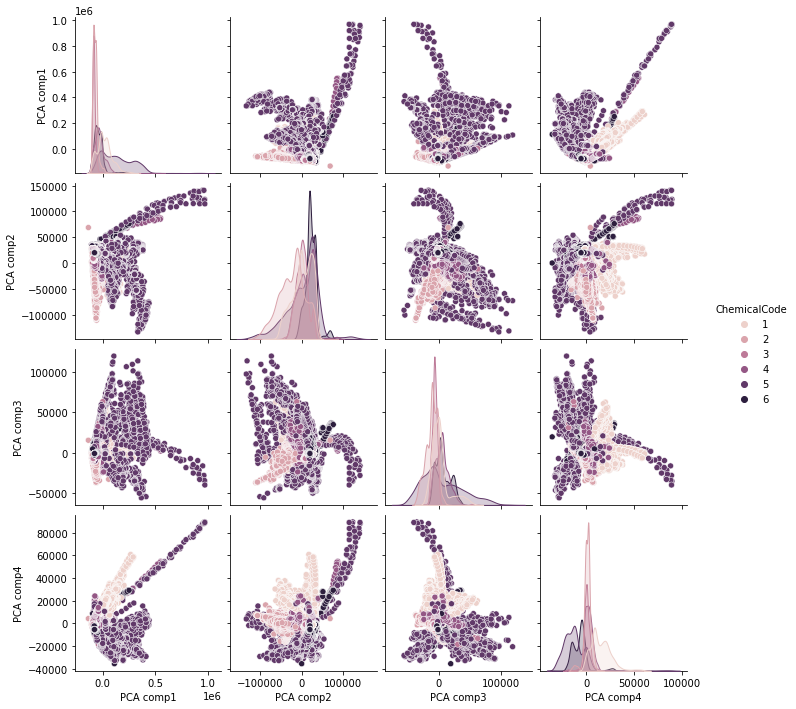

In [38]:
fig = plt.figure(figsize=(20,20))
sns.pairplot(PCA_transform, hue='ChemicalCode')
plt.show()